In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
from scipy.spatial import Delaunay
import imageio

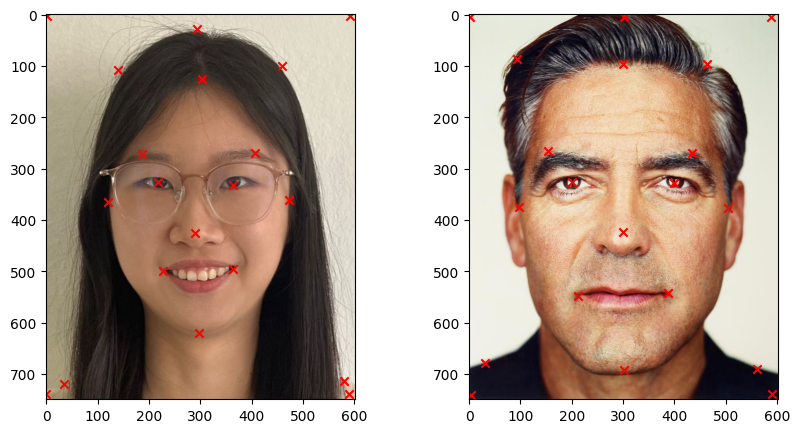

In [4]:
# part 1
with open('selfportrait_george.json') as f:
    data = json.load(f)
    
im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

im1 = cv2.imread(f"{im1_name}.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)  
im2 = cv2.imread(f"{im2_name}.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)  
self_portrait = im1
self_portrait_keypoints = im1_points

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.scatter(im1_points[:, 0], im1_points[:, 1], c='r', marker='x')
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.scatter(im2_points[:, 0], im2_points[:, 1], c='r', marker='x')

plt.show()

In [5]:
# part 2
def compute_affine_transform(src_tri, dst_tri):
    src_matrix = np.array([[src_tri[0][0], src_tri[0][1], 1],
                           [src_tri[1][0], src_tri[1][1], 1],
                           [src_tri[2][0], src_tri[2][1], 1]])
    dst_matrix = np.array([[dst_tri[0][0], dst_tri[0][1]],
                       [dst_tri[1][0], dst_tri[1][1]],
                       [dst_tri[2][0], dst_tri[2][1]]]) 

    affine_matrix = np.linalg.inv(src_matrix).dot(dst_matrix)
    return affine_matrix.T

def warp_affine(src, A, size):
    height, width = size[1], size[0]
    dst = np.zeros((height, width, src.shape[2]), dtype=src.dtype)
    x_dst, y_dst = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    coords_dst = np.vstack([x_dst.ravel(), y_dst.ravel(), np.ones(x_dst.size)])
    A_inv = np.linalg.inv(np.vstack([A, [0, 0, 1]]))[:2]
    src_coords = A_inv @ coords_dst
    src_x, src_y = src_coords.reshape(2, height, width)
    x1, y1 = np.floor(src_x).astype(int), np.floor(src_y).astype(int)
    a, b = src_x - x1, src_y - y1
    x1, y1 = np.clip(x1, 0, src.shape[1] - 2), np.clip(y1, 0, src.shape[0] - 2)
    x2, y2 = x1 + 1, y1 + 1
    I11 = src[y1, x1]
    I12 = src[y1, x2]
    I21 = src[y2, x1]
    I22 = src[y2, x2]
    for c in range(src.shape[2]):
        dst[..., c] = ((1 - a) * (1 - b) * I11[..., c] + a * (1 - b) * I12[..., c] +
                       (1 - a) * b * I21[..., c] + a * b * I22[..., c])
    return dst

def warp_triangle(img, src_tri, dst_tri, size):
    warp_mat = compute_affine_transform(src_tri, dst_tri)
    # warped_img = cv2.warpAffine(img, warp_mat, (size[1], size[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    warped_img = warp_affine(img, warp_mat, (size[1], size[0]))
    return warped_img

def generate_midway_face(im1, im2, im1_points, im2_points, average_points, tri):
    midway_face = np.zeros_like(im1)
    
    for t in tri.simplices:
        tri_im1 = im1_points[t]
        tri_im2 = im2_points[t]
        tri_avg = average_points[t]
        
        r = cv2.boundingRect(np.float32([tri_avg]))
        
        tri_im1_offset = tri_im1 - r[:2]
        tri_im2_offset = tri_im2 - r[:2]
        tri_avg_offset = tri_avg - r[:2]
        
        mask = np.zeros((r[3], r[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(tri_avg_offset), 1)
        
        warp_im1 = warp_triangle(im1[r[1]:r[1] + r[3], r[0]:r[0] + r[2]], tri_im1_offset, tri_avg_offset, (r[3], r[2]))
        warp_im2 = warp_triangle(im2[r[1]:r[1] + r[3], r[0]:r[0] + r[2]], tri_im2_offset, tri_avg_offset, (r[3], r[2]))
        
        midway_face[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] = midway_face[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] * (1 - mask[..., None]) + (warp_im1 / 2 + warp_im2 / 2) * mask[..., None]
    
    return midway_face

def draw_triangulation(image, points, triangles, color=(0, 255, 0)):
    img_copy = image.copy()
    for tri in triangles:
        pts = np.array([points[tri[0]], points[tri[1]], points[tri[2]]], np.int32)
        cv2.polylines(img_copy, [pts], isClosed=True, color=color, thickness=1)
    return img_copy


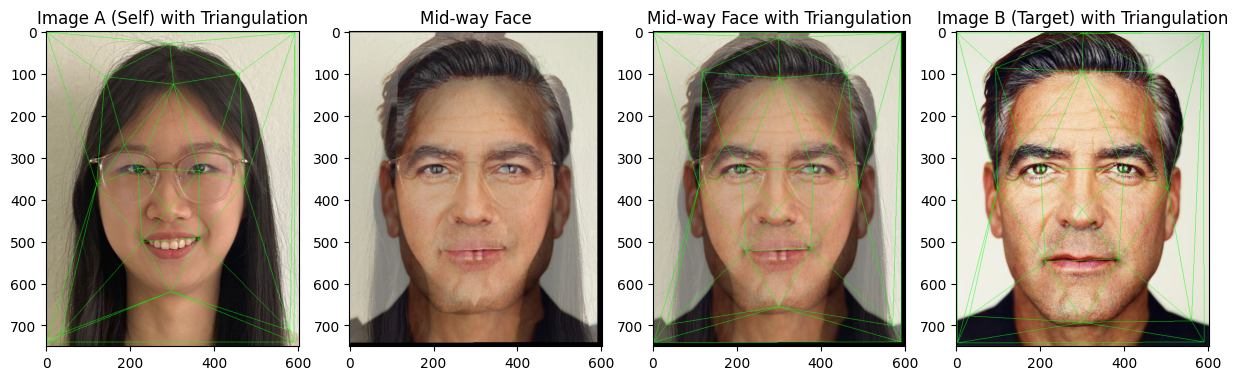

In [6]:
average_points = (im1_points + im2_points) / 2
tri = Delaunay(average_points)

midway_face = generate_midway_face(im1, im2, im1_points, im2_points, average_points, tri)
triangulated_im1 = draw_triangulation(im1, im1_points, tri.simplices)
triangulated_im2 = draw_triangulation(im2, im2_points, tri.simplices)
triangulated_mid = draw_triangulation(midway_face, average_points, tri.simplices)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(triangulated_im1)
plt.title("Image A (Self) with Triangulation")
plt.subplot(1, 4, 2)
plt.imshow(midway_face)
plt.title("Mid-way Face")
plt.subplot(1, 4, 3)
plt.imshow(triangulated_mid)
plt.title("Mid-way Face with Triangulation")
plt.subplot(1, 4, 4)
plt.imshow(triangulated_im2)
plt.title("Image B (Target) with Triangulation")
plt.show()

In [7]:
# Part 3
def morph(im1, im2, im1_points, im2_points, tri, warp_frac, dissolve_frac):
    interp_points = (1 - warp_frac) * im1_points + warp_frac * im2_points

    morphed_image = np.zeros_like(im1)
    
    for t in tri.simplices:
        tri_im1 = im1_points[t]
        tri_im2 = im2_points[t]
        tri_interp = interp_points[t]

        r = cv2.boundingRect(np.float32([tri_interp]))

        tri_im1_offset = tri_im1 - r[:2]
        tri_im2_offset = tri_im2 - r[:2]
        tri_interp_offset = tri_interp - r[:2]

        mask = np.zeros((r[3], r[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(tri_interp_offset), 1)

        warp_im1 = warp_triangle(im1[r[1]:r[1] + r[3], r[0]:r[0] + r[2]], tri_im1_offset, tri_interp_offset, (r[3], r[2]))
        warp_im2 = warp_triangle(im2[r[1]:r[1] + r[3], r[0]:r[0] + r[2]], tri_im2_offset, tri_interp_offset, (r[3], r[2]))

        blended_tri = (1 - dissolve_frac) * warp_im1 + dissolve_frac * warp_im2
        morphed_image[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] = morphed_image[r[1]:r[1] + r[3], r[0]:r[0] + r[2]] * (1 - mask[..., None]) + blended_tri * mask[..., None]

    return morphed_image

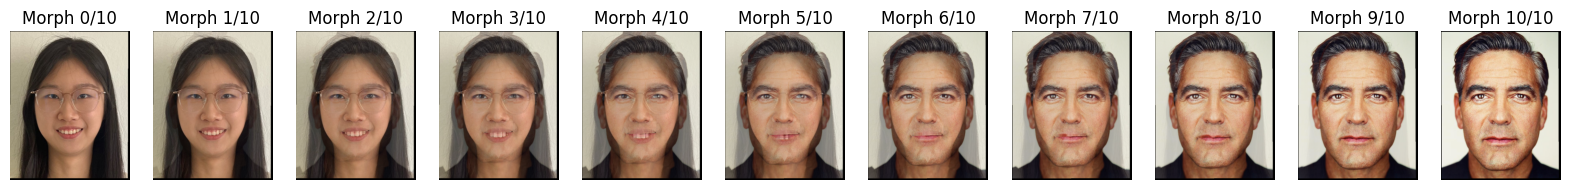

In [8]:
n_frames = 10
morph_sequence = []

for i in range(n_frames + 1):
    warp_frac = i / n_frames
    dissolve_frac = i / n_frames
    morphed_image = morph(im1, im2, im1_points, im2_points, tri, warp_frac, dissolve_frac)
    morph_sequence.append(morphed_image)

plt.figure(figsize=(20, 10))

n_frames = len(morph_sequence)

for i in range(n_frames):
    plt.subplot(1, n_frames, i + 1)
    plt.imshow(morph_sequence[i].astype(np.uint8))
    plt.axis('off')  
    plt.title(f"Morph {i}/{n_frames - 1}")
    
plt.show()

In [9]:
output_gif = 'morph_sequence.gif'
imageio.mimsave(output_gif, [morph.astype(np.uint8) for morph in morph_sequence], duration=0.05)
print(f"GIF saved as {output_gif}")

GIF saved as morph_sequence.gif


In [10]:
# part 4
from scipy.spatial import Delaunay
def parse_asf_file(asf_path):
    with open(asf_path, 'r') as file:
        lines = file.readlines()
    
    lines = [line.strip() for line in lines if line.strip() and not line.startswith('#')]
    
    num_points = int(lines[0])
    
    keypoints = []
    for line in lines[1:num_points + 1]:
        parts = line.split()
        x_rel = float(parts[2])
        y_rel = float(parts[3])
        keypoints.append((x_rel, y_rel))
    
    return keypoints

def convert_to_pixel_coordinates(keypoints, img_path):
    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    pixel_coords = [(int(x * width), int(y * height)) for x, y in keypoints]
    return pixel_coords

def warp_to_average_shape(img, src_keypoints, dst_keypoints):
    zeros = np.zeros_like(img)
    tri = Delaunay(dst_keypoints)
    src_keypoints = np.array(src_keypoints)
    dst_keypoints = np.array(dst_keypoints)
    morphed_image = morph(img, zeros, src_keypoints, dst_keypoints, tri, 1, 0)
        
    return morphed_image

def add_corner_points(image, points):
            h, w = image.shape[:2]
            corner_points = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
            return np.vstack([points, corner_points])

Found 33 valid keypoints
Found 33 ASF files


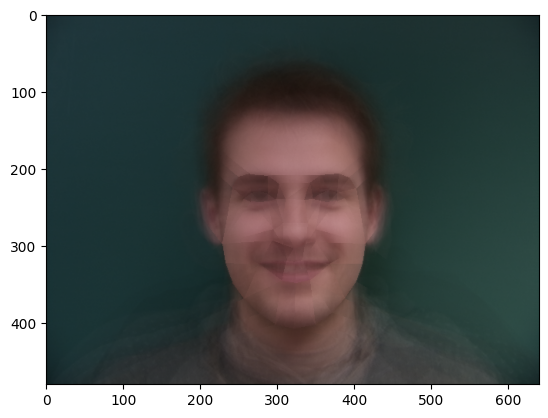

In [11]:
asf_dir = "imm_face_db"
img_dir = "imm_face_db"
asf_files = [f for f in os.listdir(asf_dir) if f.endswith("-2m.asf")]
img_files = [f for f in os.listdir(asf_dir) if f.endswith("-2m.jpg")]
img_list = []
keypoints_list = []

for filename in asf_files:
    asf_path = os.path.join(asf_dir, filename)
    img_path = os.path.join(img_dir, filename.replace(".asf", ".jpg"))
    
    if not os.path.exists(img_path):
        print(f"Image not found for {filename}")
        continue
    try:
        img = cv2.imread(img_path)
        img_list.append(img)
        keypoints = parse_asf_file(asf_path)
        pixel_keypoints = convert_to_pixel_coordinates(keypoints, img_path)
        pixel_keypoints = add_corner_points(img, pixel_keypoints)
        keypoints_list.append(pixel_keypoints)
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"Found {len(keypoints_list)} valid keypoints")
print(f"Found {len(asf_files)} ASF files")


mean_keypoints = np.mean(np.array(keypoints_list), axis=0)


warped_images = []
for i, filename in enumerate(asf_files):
    try:
        img_path = os.path.join(img_dir, filename.replace(".asf", ".jpg"))
        img = cv2.imread(img_path)
        warped_img = warp_to_average_shape(img, keypoints_list[i], mean_keypoints)
        warped_images.append(warped_img)
    except IndexError:
        print(f"Index out of range for {filename}. Skipping.")
    except Exception as e:
        print(f"Error warping {filename}: {e}")

# for i in range(10):
#     cv2.imshow('Face', draw_triangulation(img_list[i], keypoints_list[i], tri.simplices))
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

avg_face = np.mean(np.stack(warped_images), axis=0).astype(np.uint8)
plt.imshow(cv2.cvtColor(avg_face, cv2.COLOR_BGR2RGB))

In [12]:
cv2.imwrite('average_face.jpg', avg_face)

True

In [13]:
# part 5
# crop images first
height, width, channels = avg_face.shape

target_width = 384
target_height = 480

left_margin = (width - target_width) // 2
right_margin = left_margin + target_width
cropped_img = avg_face[:, left_margin:right_margin]
top_margin = (height - target_height) // 2
bottom_margin = top_margin + target_height
cropped_img = cropped_img[top_margin:bottom_margin, :]
cv2.imwrite('average_face_cropped.jpg', cropped_img)

self_portrait = cv2.imread("selfportrait.jpg")
self_portrait_cropped = cv2.resize(self_portrait, (target_width, target_height))
cv2.imwrite("selfportrait_cropped.jpg", self_portrait_cropped) 

True

selfportrait_cropped


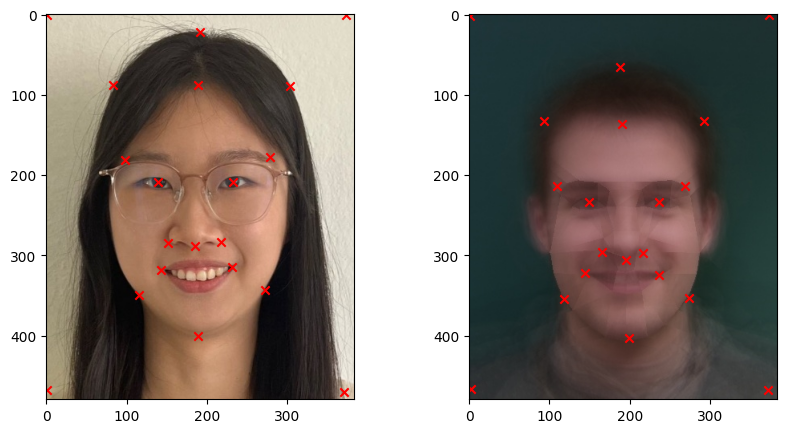

In [14]:
with open('selfportrait_cropped_average_face_cropped.json') as f:
    data = json.load(f)
    
im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

print(im1_name)
im1 = cv2.imread(f"{im1_name}.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB) 
im1 = cv2.resize(im1, (384, 480), interpolation=cv2.INTER_AREA) 
im2 = cv2.imread(f"{im2_name}.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)  

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.scatter(im1_points[:, 0], im1_points[:, 1], c='r', marker='x')
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.scatter(im2_points[:, 0], im2_points[:, 1], c='r', marker='x')

plt.show()

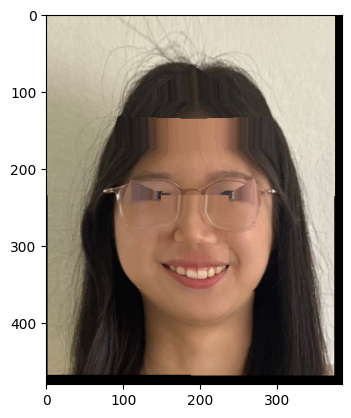

In [15]:
warped_img = warp_to_average_shape(im1, im1_points, im2_points)
plt.imshow(warped_img)

Found 7 valid keypoints
Found 7 ASF files


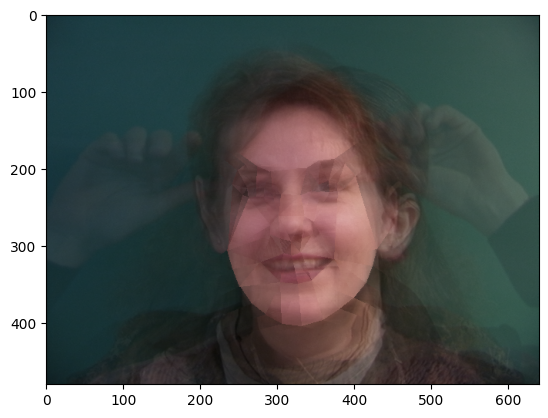

In [29]:
# Bell and Whistle
asf_dir = "imm_face_db"
img_dir = "imm_face_db"
asf_files = [f for f in os.listdir(asf_dir) if f.endswith("-6f.asf")]
img_files = [f for f in os.listdir(asf_dir) if f.endswith("-6f.jpg")]
img_list = []
keypoints_list = []

for filename in asf_files:
    asf_path = os.path.join(asf_dir, filename)
    img_path = os.path.join(img_dir, filename.replace(".asf", ".jpg"))
    
    if not os.path.exists(img_path):
        print(f"Image not found for {filename}")
        continue
    try:
        img = cv2.imread(img_path)
        img_list.append(img)
        keypoints = parse_asf_file(asf_path)
        pixel_keypoints = convert_to_pixel_coordinates(keypoints, img_path)
        pixel_keypoints = add_corner_points(img, pixel_keypoints)
        keypoints_list.append(pixel_keypoints)
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"Found {len(keypoints_list)} valid keypoints")
print(f"Found {len(asf_files)} ASF files")


mean_keypoints = np.mean(np.array(keypoints_list), axis=0)


warped_images = []
for i, filename in enumerate(asf_files):
    try:
        img_path = os.path.join(img_dir, filename.replace(".asf", ".jpg"))
        img = cv2.imread(img_path)
        warped_img = warp_to_average_shape(img, keypoints_list[i], mean_keypoints)
        warped_images.append(warped_img)
    except IndexError:
        print(f"Index out of range for {filename}. Skipping.")
    except Exception as e:
        print(f"Error warping {filename}: {e}")

# for i in range(10):
#     cv2.imshow('Face', draw_triangulation(img_list[i], keypoints_list[i], tri.simplices))
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

avg_face = np.mean(np.stack(warped_images), axis=0).astype(np.uint8)
plt.imshow(cv2.cvtColor(avg_face, cv2.COLOR_BGR2RGB))

In [30]:
height, width, channels = avg_face.shape

target_width = 384
target_height = 480

left_margin = (width - target_width) // 2
right_margin = left_margin + target_width
cropped_img = avg_face[:, left_margin:right_margin]
top_margin = (height - target_height) // 2
bottom_margin = top_margin + target_height
cropped_img = cropped_img[top_margin:bottom_margin, :]
cv2.imwrite('afc1.jpg', cropped_img)


True

selfportrait_cropped


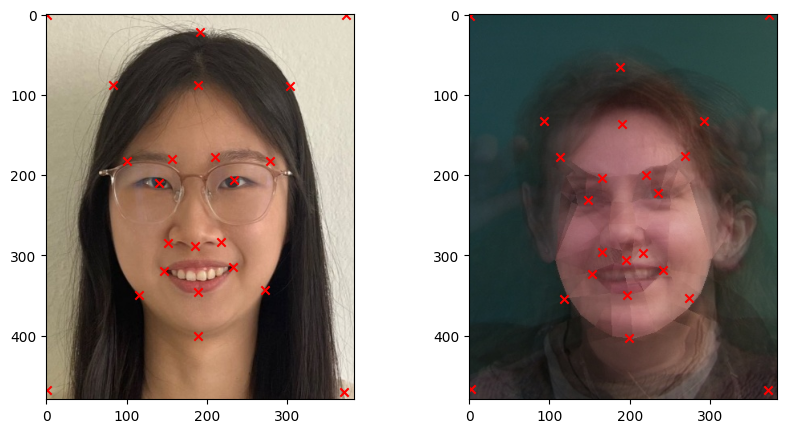

In [31]:
with open('selfportrait_cropped_afc1.json') as f:
    data = json.load(f)
    
im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

print(im1_name)
im1 = cv2.imread(f"{im1_name}.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB) 
im1 = cv2.resize(im1, (384, 480), interpolation=cv2.INTER_AREA) 
im2 = cv2.imread(f"{im2_name}.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)  

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.scatter(im1_points[:, 0], im1_points[:, 1], c='r', marker='x')
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.scatter(im2_points[:, 0], im2_points[:, 1], c='r', marker='x')

plt.show()

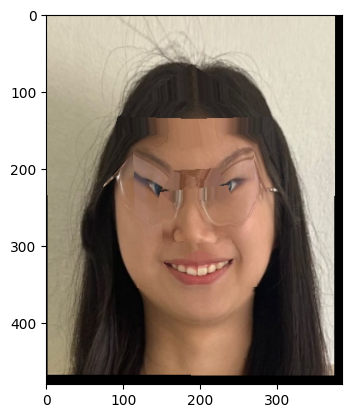

In [32]:
warped_img = warp_to_average_shape(im1, im1_points, im2_points)
plt.imshow(warped_img)